# Cell assembly analyses

In [1]:
%cd ..

D:\ryanh\github\cell_assembly_replay


In [7]:
import itertools
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
from cell_assembly_replay import assembly,assembly_run
import pandas as pd
import nelpy as nel
import nelpy.io
import nelpy.plotting as npl
import multiprocessing
from joblib import Parallel, delayed
import pickle
import glob

## load example data

In [3]:
# output files are saved here
save_path = 'F:/Projects/PAE_PlaceCell/analysis/cell_assembly/'
# where base data will be read in from
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
# where spike times will be read in
spike_path = 'F:/Projects/PAE_PlaceCell/analysis/spikes/'
# data frame contain info for each unit
df_cell_class = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/cell_recruitment/processed/pyr_int_df.csv')
# data frame contain info for each ripple
swr_df = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/swr_data/post_processed/swr_df.csv')

## run all sessions

In [5]:
assembly_run.assembly_run(spike_path,save_path,swr_df)

## pull in data for comparison

In [17]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + '*.pkl')
    
    session_ = []
    assembl_strength = []
    assembl_frac = []
    n_assembl = []
    n_units = []
    n_assembl_n_cell_frac = []
    n_cells_per_assembl = []

    for session in sessions:
            with open(session, 'rb') as f:
                results = pickle.load(f)

            session_.append(results['session'])
            assembl_strength.append(results['assembl_strength'])
            assembl_frac.append(results['assembl_frac'])
            n_assembl.append(results['n_assembl'])
            n_units.append(results['n_units'])
            n_assembl_n_cell_frac.append(results['n_assembl_n_cell_frac'])
            n_cells_per_assembl.append(results['n_cells_per_assembl'])
                
    results = {
        "session": session_,
        "assembl_strength": list(itertools.chain(*assembl_strength)),
        "assembl_frac": list(itertools.chain(*assembl_frac)),
        "n_assembl": n_assembl,
        "n_units": n_units,
        "n_assembl_n_cell_frac": n_assembl_n_cell_frac,
        "n_cells_per_assembl": n_cells_per_assembl
        }     
    return results

results = load_in_everything(save_path)
results.keys()

dict_keys(['session', 'assembl_strength', 'assembl_frac', 'n_assembl', 'n_units', 'n_assembl_n_cell_frac', 'n_cells_per_assembl'])

In [33]:
for item in results.keys():
    print(len(results[item]))

189
18204
18204
189
189
189
189


# Testing below

## bin spikes

In [49]:
# load spikes & add to object
spikes = np.load(os.path.join(spike_path,session)+'.npy',allow_pickle=True)
spikes_ = list(itertools.chain(*spikes))

session_bounds = nel.EpochArray([min(spikes_),max(spikes_)])
st = nel.SpikeTrainArray(timestamps=spikes,support=session_bounds, fs=32000)

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


In [50]:
dt = 0.02
binned_st = st.bin(ds=0.02)

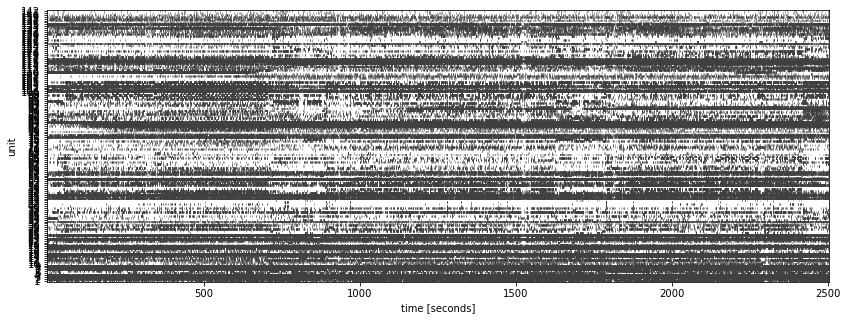

In [51]:
fig, ax = plt.subplots(ncols=1, figsize=(14,5))
npl.rasterplot(st, lw=0.5, ax=ax)
ax.set_xlabel('time [seconds]')
ax.set_ylabel('unit')
ax.set_xlim(*session_bounds.time);

In [52]:
patterns, significance, zactmat = assembly.runPatterns(binned_st.data)

In [53]:
assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)

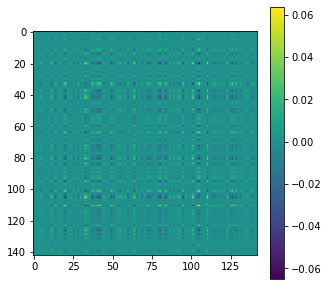

In [54]:
plt.figure(figsize=(5,5))
projMat = np.corrcoef(significance.components_,rowvar=False)
projMat -= True*np.diag(np.diag(projMat))
plt.imshow(projMat)
plt.colorbar()

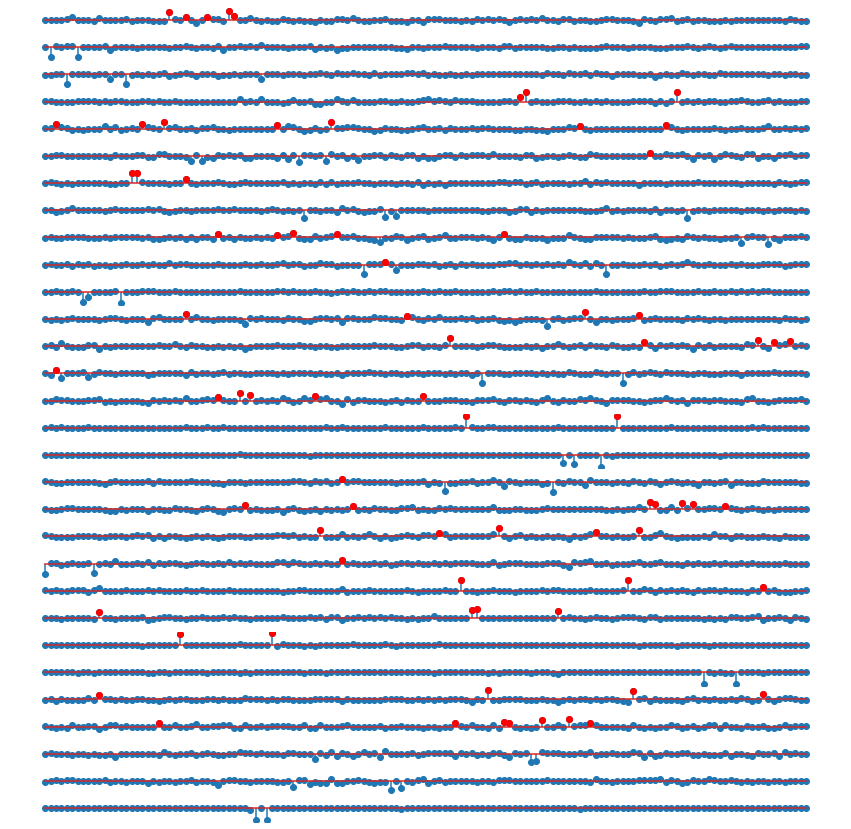

In [55]:
fig, axs = plt.subplots(patterns.shape[0],1, figsize=(15, 15), edgecolor='k')
fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()


for i,assmbl in enumerate(patterns):
    axs[i].stem(np.arange(len(assmbl)),assmbl)
    thres = np.mean(assmbl) + np.std(assmbl)*2
    idx = assmbl > thres
    axs[i].scatter(np.arange(len(assmbl))[idx],assmbl[idx],color='red',zorder=1000)
    
for i in range(patterns.shape[0]):
    axs[i].set_ylim(-patterns.max()-.1,patterns.max()+.1)
    axs[i].axis('off')

In [57]:
assembly_act = nel.AnalogSignalArray(assemblyAct, timestamps=binned_st.bin_centers,fs=1/dt)
assembly_act

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


<AnalogSignalArray at 0x1f2802f3eb0: 30 signals> for a total of 41:40:125 minutes

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


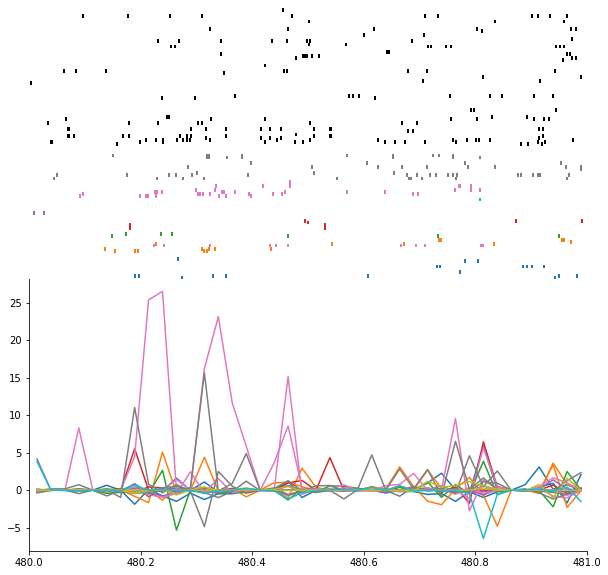

In [171]:
import matplotlib

def plot_assembl_strength(binned_st,st,patterns,assembly_act,interval,axs,show_not_in_assmbl=True):
    

    cmap = matplotlib.cm.get_cmap('tab10',patterns.shape[0])

    interval = nel.EpochArray(interval)
    st = st[interval]

    assembly_act = assembly_act[interval]
    binned_st = binned_st[interval]

    assmbl_unit_id = []
    assmbl_unit_id_store = []
    for i,assmbl in enumerate(patterns):
        thres = np.mean(assmbl) + np.std(assmbl)*2
        assmbl_unit_id = np.where(assmbl > thres)
        assmbl_unit_id_store.append(assmbl_unit_id[0])
        
        if assmbl_unit_id[0].size > 0:
            npl.rasterplot(st[:,assmbl_unit_id[0]+1], lw=2, lh=2, color=cmap(i), ax=axs[0], vertstack=True)
            
            axs[1].plot(binned_st.bin_centers,assembly_act.data[i,:], color=cmap(i))

    # plot units not an assmbl
    if show_not_in_assmbl:
        assmbl_unit_id_store_ = list(itertools.chain(*assmbl_unit_id_store))
        not_in_assmbl = np.where([val not in assmbl_unit_id_store_ for val in np.arange(st.n_units)])
        npl.rasterplot(st[:,not_in_assmbl[0]+1], lw=2, lh=2, color='k', ax=axs[0], vertstack=True)
    
    axs[0].set_xlim(interval.data[0][0],interval.data[0][1])
    axs[1].set_xlim(interval.data[0][0],interval.data[0][1])
    
#     axs[0].autoscale(enable=True, axis='both', tight=True)
#     axs[1].autoscale(enable=True, axis='both', tight=True)

    axs[0].axis('off')
    
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["top"].set_visible(False)
    


fig, axs = plt.subplots(2,1, figsize=(10, 10), edgecolor='k')
fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()    
plot_assembl_strength(binned_st,st,patterns,assembly_act,[480,481],axs)

    # axs[0].set_xlim(*session_bounds.time)
    # axs[1].set_xlim(*session_bounds.time)


#     axs[0].set_xlim(757,758.5)
#     axs[1].set_xlim(757,758.5)

#     axs[1].set_ylim(-4,100)

(0.0, 300.0)

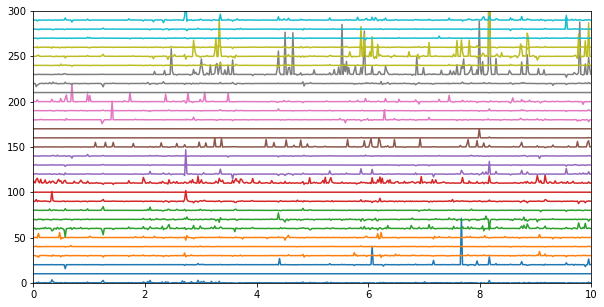

In [199]:
plt.figure(figsize=(10,5))
cmap = matplotlib.cm.get_cmap('tab10',assembly_act.n_signals)

for i in range(assembly_act.n_signals):
    plt.plot(binned_st.bin_centers,assembly_act.data[i,:] + i*10, color=cmap(i))
plt.xlim(0,10)
plt.ylim(0,300)

In [ ]:
ratemap = assembly_act.data[:,0:1000]
pad = 2
color=None
fill=True
xmin = 0 
xmax = ratemap.shape[1]
xvals = np.arange(ratemap.shape[1])
n_units = ratemap.shape[0]
# if unit_labels is None:
#     unit_labels = ratemap.unit_labels
# ratemap = ratemap.ratemap
  
fig, ax = plt.subplots(figsize=(10, 5), edgecolor='k')


for unit, curve in enumerate(ratemap):
    if color is None:
        line = ax.plot(xvals, unit*pad + curve, zorder=int(10+2*n_units-2*unit))
    else:
        line = ax.plot(xvals, unit*pad + curve, zorder=int(10+2*n_units-2*unit), color=color)
    if fill:
        # Get the color from the current curve
        fillcolor = line[0].get_color()
        ax.fill_between(xvals, unit*pad, unit*pad + curve, alpha=0.3, color=fillcolor, zorder=int(10+2*n_units-2*unit-1))
        
ax.set_xlim(xmin, xmax)


In [ ]:
axs[1].plot(binned_st.bin_centers,assembly_act.data[i,:], color=cmap(i))


In [ ]:
session = 'LEM3124_S20190302163218'
results = run_all(session,spike_path)

In [ ]:
results

In [34]:
# load spikes & add to object
spikes = np.load(os.path.join(spike_path,session)+'.npy', allow_pickle=True)
spikes_ = list(itertools.chain(*spikes))
session_bounds = nel.EpochArray([min(spikes_), max(spikes_)])
st = nel.SpikeTrainArray(timestamps=spikes, support=session_bounds, fs=32000)

dt = 0.025
binned_st = st.bin(ds=dt)

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


In [31]:
assemblyAct = results['assemblyAct']

In [29]:
swr_df = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/swr_data/post_processed/swr_df.csv')


In [ ]:
# Assembly reactivation strength during SPW-R periods

# Assembly strength was defined as the mean activation strength of all events (R > 5)
# across single postexploration sessions occurring during time periods detected as
# sharp wave ripples (described above).

In [191]:
patterns.shape[1]


142

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


13.671150934701837

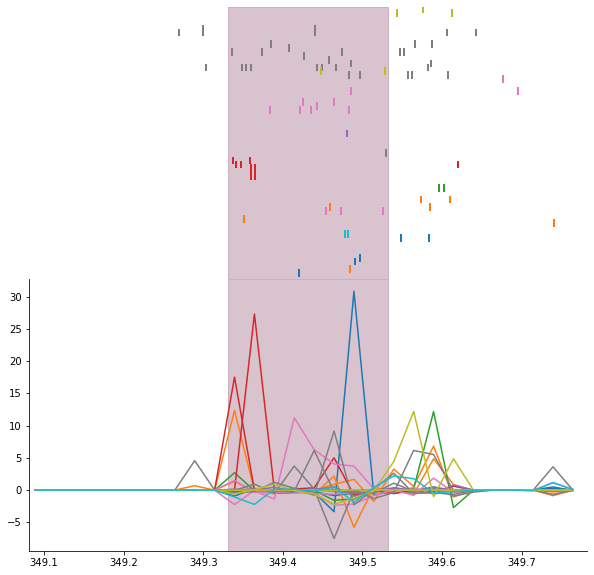

In [177]:
event = swr_df[swr_df.session == session].iloc[17]


fig, axs = plt.subplots(2,1, figsize=(10,10), edgecolor='k')
fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()    
plot_assembl_strength(binned_st,st,patterns,assembly_act,[event.start_time-.25, event.end_time+.25],axs,show_not_in_assmbl=False)
axs[0].axvspan(event.start_time, event.end_time, alpha=0.3, color='#843b62', zorder=-1000)
axs[1].axvspan(event.start_time, event.end_time, alpha=0.3, color='#843b62', zorder=-1000)
    
# event = swr_df[swr_df.session == session].iloc[15]

# axs[0].axvspan(event.start_time, event.end_time, alpha=0.3, color='#843b62', zorder=-1000)
# axs[1].axvspan(event.start_time, event.end_time, alpha=0.3, color='#843b62', zorder=-1000)

curr_assembl = assemblyAct[:,(binned_st.bin_centers >= event.start_time) & (binned_st.bin_centers <= event.end_time)]
curr_assembl[curr_assembl > 5].mean()

In [195]:
patterns.shape

(30, 142)

In [217]:
# patterns[0]

# thres = np.mean(assmbl) + np.std(assmbl)*2

n_cells_per_assembl = np.sum(patterns > (patterns.mean(axis=1) + patterns.std(axis=1)*2)[:, np.newaxis],axis=1)
n_cells_per_assembl[n_cells_per_assembl > 0]

array([6, 5, 6, 6, 4, 3, 5, 2, 4, 3, 1, 4, 6, 5, 7, 4, 2, 5, 2])

In [ ]:
# n_cells_per_assembly
for i,assmbl in enumerate(patterns):
    thres = np.mean(assmbl) + np.std(assmbl)*2
    assmbl_unit_id = sum(assmbl > thres)


In [69]:
patterns = results['patterns']
assembly_act = nel.AnalogSignalArray(assemblyAct, timestamps=binned_st.bin_centers,fs=1/dt)
assembly_act.data

(30, 100005)

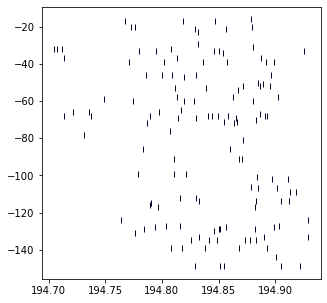

In [140]:
# plot_assembl_strength(binned_st,st,patterns,assembly_act,[event.start_time, event.end_time],show_not_in_assmbl=True)

 
fig, ax = plt.subplots(1,1,figsize=(5, 5))    


def plot_assembl_example(st,assembly_act,interval):
    lower_lim = interval[0]
    upper_lim = interval[1]

    # plot spike raster within window
    for i,s in enumerate(st.data):
        s = s[(s >= lower_lim) & (s <= upper_lim)]
        ax.plot(s,np.zeros(len(s))-15-i,'|',color='#0b032a')
        
plot_assembl_example(st,[event.start_time, event.end_time])        

In [ ]:
# fraction of active assemblies active during spw-r

# Activation of multiple assemblies within
# single ripple events were quantified as the number active, as a fraction of the total
# number identified for that session.

In [188]:
 curr_assembl.shape

(30, 8)

In [189]:
sum(np.any(curr_assembl > 5,axis=1)) / curr_assembl.shape[0]

0.4

In [ ]:
# multi-assembly strength

In [ ]:
# multi-assembly rate